# Imports

In [1]:
import os
os.chdir("D:\PulpitE\FPL_ML")

In [2]:
import pandas as pd

import torch
import torch.nn as nn

import torchvision
import torchvision.transforms

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import matplotlib.pyplot as plt

import numpy as np
import random

# Constants and seeds

In [3]:
# FIXTURES_IN_SAMPLE
FIS = 8
# FIXTURES_FOR_PLAYER
FFP = 15

In [4]:
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_all_seeds(42)

# Data

In [5]:
df = pd.read_csv('data/fpl_fbref_elo_players.csv')

In [6]:
# remembering original df
df_original = df

In [7]:
info = ["Name", "GW"]
other = ["LSTM"]
features = ["Min", "Gls", "Sh", "SoT", "xG", "npxG", "xAG", "CS", "Was Home"]
to_predict = ["FPL"]

In [8]:
df = df[info + features + to_predict]
df[features + to_predict] = df[features + to_predict].astype("float32")

C:\users\user\appdata\local\programs\python\python38\lib\site-packages\pandas\core\frame.py:3636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [9]:
df.shape

(6104, 12)

In [10]:
# removing NaN rows and players that appear less than 15 times
df = df.dropna()
grouped = df.groupby('Name')
df = grouped.filter(lambda x: len(x) >= FFP)

In [11]:
df.shape

(4080, 12)

In [12]:
df.head(FFP)

,Name,GW,Min,Gls,Sh,SoT,xG,npxG,xAG,CS,Was Home,FPL
0,Brenden-Aaronson,4,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
1,Brenden-Aaronson,5,75.0,0.0,1.0,1.0,0.1,0.1,0.1,0.0,1.0,5.0
2,Brenden-Aaronson,6,90.0,0.0,1.0,0.0,0.0,0.0,0.3,0.0,0.0,2.0
3,Brenden-Aaronson,9,78.0,0.0,0.0,0.0,0.0,0.0,0.1,1.0,1.0,3.0
4,Brenden-Aaronson,10,75.0,0.0,2.0,0.0,0.1,0.1,0.0,0.0,0.0,2.0
5,Brenden-Aaronson,11,90.0,0.0,2.0,1.0,0.1,0.1,0.3,0.0,1.0,2.0
6,Brenden-Aaronson,12,90.0,0.0,1.0,0.0,0.1,0.1,0.4,0.0,0.0,2.0
7,Brenden-Aaronson,13,90.0,0.0,1.0,0.0,0.1,0.1,0.9,0.0,1.0,2.0
8,Brenden-Aaronson,14,90.0,0.0,2.0,0.0,0.2,0.2,0.2,0.0,0.0,2.0
9,Brenden-Aaronson,15,85.0,0.0,2.0,0.0,0.1,0.1,0.0,0.0,1.0,2.0


In [13]:
last_names = df["Name"].unique()

# DF to DataLoader

In [14]:
def split_indices(index):
    return (index // (FFP-FIS)), (index % (FFP-FIS))

In [15]:
split_indices(11)

(1, 4)

In [16]:
from torchvision.transforms import ToTensor

class PandasDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.names = dataframe["Name"].unique()
        self.transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

    def __len__(self):
        return len(self.names) * (FFP-FIS)

    def __getitem__(self, idx):
        # print(idx)
        player_id, sample_id = split_indices(idx)
        name = self.names[player_id]
        # print(name)
        features = self.dataframe[self.dataframe["Name"] == name]
        # print(self.dataframe[self.dataframe["Name"] == name])
        # print(features[sample_id: (sample_id + 4)])
        features = features[sample_id: (sample_id + FIS - 1)].drop(columns=info).values[:, :-1]
        # print(features)
        # print(features)
        # print(type(features))
        # print(self.dataframe[self.dataframe["Name"] == name].values[:, -1])
        # print(type(self.dataframe[self.dataframe["Name"] == name].values[:, -1]))
        # target = self.dataframe[self.dataframe["Name"] == name].values[:, -1]
        # target = target.astype(np.float32)
        # target = torch.from_numpy(target)
        target = np.float32(self.dataframe[self.dataframe["Name"] == name].values[(sample_id + FIS), -1])
        # print(name, idx, target, sample_id)
        # print(type(target))
        return features, target

In [17]:
dataset = PandasDataset(df)
dataset.__getitem__(5)

(array([[90. ,  0. ,  2. ,  1. ,  0.1,  0.1,  0.3,  0. ,  1. ],
        [90. ,  0. ,  1. ,  0. ,  0.1,  0.1,  0.4,  0. ,  0. ],
        [90. ,  0. ,  1. ,  0. ,  0.1,  0.1,  0.9,  0. ,  1. ],
        [90. ,  0. ,  2. ,  0. ,  0.2,  0.2,  0.2,  0. ,  0. ],
        [85. ,  0. ,  2. ,  0. ,  0.1,  0.1,  0. ,  0. ,  1. ],
        [90. ,  0. ,  2. ,  0. ,  0.1,  0.1,  0.4,  0. ,  0. ],
        [82. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ]],
       dtype=float32),
 2.0)

In [18]:
batch_size = 16

In [19]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [20]:
next(iter(dataloader))[1]

tensor([2., 2., 5., 2., 3., 2., 2., 1., 2., 2., 7., 2., 2., 2., 2., 2.])

# LSTM Model

In [21]:
class LSTMNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMNetwork, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.transpose(x, 0, 1)
        # x = x.view(-1, batch_size)
        # x = torch.transpose(x, 0, 1)
        # print("FOR", x.shape)
        # print(x.shape)
        # print(x.shape)
        out, _ = self.lstm(x)
        # print(out.shape)
        out = self.fc(out[-1])
        return out

In [22]:
len(dataloader)

119

In [23]:
torch.transpose(next(iter(dataloader))[0], 0, 1).shape

torch.Size([7, 16, 9])

In [24]:
net = LSTMNetwork(1, 20, 2, 1, dropout=0.4)

# Training loop

In [25]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.005)

In [26]:
%%time
num_epochs = 100
loss_history = []
for epoch in range(num_epochs):
    running_loss = 0
    for i, (inputs, targets) in enumerate(dataloader):
        inputs = torch.flatten(inputs, 1, 2)
        inputs = inputs.unsqueeze(2)
        # print("INPUTS", inputs.shape)
        # print("TARGETS", targets.shape)
        # print(targets)
        optimizer.zero_grad()
        outputs = net(inputs).flatten()
        # print("OUTPUTS", outputs.shape)
        loss = criterion(outputs, targets)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
    
    loss_history.append(running_loss / len(dataloader))
    if epoch % 5 == 0:
        print(f'Epoch {epoch} Loss: {running_loss / len(dataloader)}')

Epoch 0 Loss: 4.085616135296702
Epoch 5 Loss: 3.3496561030379866
Epoch 10 Loss: 3.245192094510343
Epoch 15 Loss: 3.284108270867532
Epoch 20 Loss: 3.2944512309647407
Epoch 25 Loss: 3.1844788474195145
Epoch 30 Loss: 3.169596514030665
Epoch 35 Loss: 3.1273609755419884
Epoch 40 Loss: 3.1622650448013756
Epoch 45 Loss: 3.1220528255490696
Epoch 50 Loss: 3.08361901180083
Epoch 55 Loss: 3.078924884565738
Epoch 60 Loss: 3.1436435254682014
Epoch 65 Loss: 3.013714763547192
Epoch 70 Loss: 3.011878290096251
Epoch 75 Loss: 3.095811793283254
Epoch 80 Loss: 2.975344274725233
Epoch 85 Loss: 3.0907381521303114
Epoch 90 Loss: 2.9833689622518396
Epoch 95 Loss: 2.9556832649126776
CPU times: total: 50min 47s
Wall time: 14min 45s


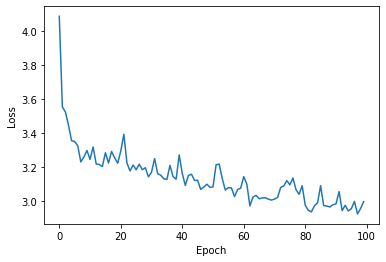

In [27]:
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Predictions

In [28]:
index = 0
predictions = []
for inputs, target in dataloader:
    inputs = torch.flatten(inputs, 1, 2)
    inputs = inputs.unsqueeze(2)
    # print("INPUTS", inputs)
    # print(inputs)
    outputs = net(inputs)
    # print("OUTPUTS", outputs)
    for output in outputs:
        player_id, sample_id = split_indices(index)
        name = last_names[player_id]
        points = round(output.item(), 2)
        gw = sample_id + FIS + 1
        predictions.append([name, gw, points])
        # df.loc[(df["Name"] == name) & (df["GW"] == gw), "LSTM"] = points
        index += 1

In [29]:
# appending results to original df
for name, gw, points in predictions:
    df_original.loc[(df_original["Name"] == name) & (df["GW"] == gw), "LSTM"] = points

In [30]:
df_original

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Date,Day,Comp,Round,Venue,Squad,Opponent,...,Team Score,Opp Score,CS,Was Home,GW,FPL,neutral_name,Total Points,Opp rating,LSTM
0,0,0,4,2022-08-27,Sat,Premier League,Matchweek 4,Away,Leeds United,Brighton,...,0,1,0.0,0.0,4,2.0,Brenden-Aaronson,1.0,1783.540161,NaN
1,1,1,5,2022-08-30,Tue,Premier League,Matchweek 5,Home,Leeds United,Everton,...,1,1,0.0,1.0,5,5.0,Brenden-Aaronson,5.0,1688.922485,NaN
2,2,2,6,2022-09-03,Sat,Premier League,Matchweek 6,Away,Leeds United,Brentford,...,2,5,0.0,0.0,6,2.0,Brenden-Aaronson,2.0,1727.113647,NaN
3,3,3,9,2022-10-02,Sun,Premier League,Matchweek 9,Home,Leeds United,Aston Villa,...,0,0,1.0,1.0,9,3.0,Brenden-Aaronson,3.0,1716.016846,3.36
4,4,4,10,2022-10-09,Sun,Premier League,Matchweek 10,Away,Leeds United,Crystal Palace,...,1,2,0.0,0.0,10,2.0,Brenden-Aaronson,5.0,1748.905396,3.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6099,6099,6099,23,2022-11-06,Sun,Premier League,Matchweek 15,Away,Arsenal,Chelsea,...,1,0,1.0,0.0,15,3.0,Martin-Odegaard,3.0,1898.455322,3.43
6100,6100,6100,25,2022-11-12,Sat,Premier League,Matchweek 16,Away,Arsenal,Wolves,...,2,0,1.0,0.0,16,13.0,Martin-Odegaard,16.0,1687.156250,NaN
6101,6101,6101,28,2022-12-26,Mon,Premier League,Matchweek 17,Home,Arsenal,West Ham,...,3,1,0.0,1.0,17,8.0,Martin-Odegaard,11.0,1768.070923,NaN
6102,6102,6102,29,2022-12-31,Sat,Premier League,Matchweek 18,Away,Arsenal,Brighton,...,4,2,0.0,0.0,18,10.0,Martin-Odegaard,13.0,1799.850708,NaN


In [31]:
df_original.to_csv("data/fpl_fbref_elo_lstm.csv")

In [32]:
# results sorted
pd.DataFrame(predictions, columns=["Name", "GW", "Points"]).sort_values(by=["Points"], ascending = False).head(20)

,Name,GW,Points
776,Erling-Haaland,15,6.26
1714,Ivan-Toney,15,6.10
1509,Bukayo-Saka,13,5.48
1740,Leandro-Trossard,13,5.41
1488,Rodrigo,13,5.27
1736,Leandro-Trossard,9,5.16
238,Jarrod-Bowen,9,5.06
1100,Martinelli,10,4.66
1901,Martin-Odegaard,13,4.56
1518,Mohamed-Salah,15,4.47
